# Turkish delight

I've been running studies on [Mechanical Turk](https://www.mturk.com/mturk/welcome) ever since I entered grad school. A while back I Googled my first mturk and found some **HORRIBLE** reviews for my first HIT and since then I've made extra effort to write HITs with clear instructions that are fun (i.e., not dreadfully unpleasant) for subjects. 

In the same spirit, I wanted to see what sorts of positive and negative comments mturkers leave about our (mturk requestors) HITs and maybe give some general advice for making better tasks. My analyses are going to be based on the [mturk](https://www.reddit.com/r/mturk/) subreddit. Note, I didn't use other subreddits like HitsWorthTurkingFor because most of those posts are just brief descriptions of the HIT--By virtue of being on that subreddit these HITs are *already* good.

The game plan is:

* Load and process (stem, lowercase) the text 
* Run a sentiment analysis so we can find the positive and negative comments
* Figure out general topics of posts within those sentiments
* Based on the negative topics, give some advice about how to make better HITs so we can all live harmoniously together. Because that's what the internet is alllllllll about

# Data setup

## Load data

First I'm going to load some packages. Typical stuff, but I'm going to use **praw** to scrape the **mturk** subreddit

In [220]:
%matplotlib inline
import praw
import pandas as pd
import numpy as np
from numpy.matlib import repmat
import scipy as sp
import os
import pickle as pk

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from IPython.display import clear_output

And I'll set up my scraper and get some Tweets

In [426]:
user_agent = (pd.read_csv('r_id.csv',header=None)[0][0]) # made this weird for privacy

r = praw.Reddit(user_agent = user_agent)
subreddit = r.get_subreddit("mturk")

In [3]:
fname='all_posts.pkl'
if not os.path.exists(fname):
    with open(fname,'wb') as post_file:
        all_posts=[sbm for sbm in subreddit.get_hot(limit = 999)]
        pk.dump(all_posts,post_file)
else:
    with open(fname,'rb') as post_file:
        all_posts=pk.load(post_file)


In [197]:
all_text=[]
for ind,subm in enumerate(all_posts):
    all_text.append(subm.selftext)

all_data=pd.DataFrame({'raw_text':all_text})
all_data=all_data.loc[all_data.raw_text!='',:].reset_index()
all_data.drop('index',axis=1,inplace=True)

In [198]:
all_data.head()

,raw_text
0,"Before posting to /r/mturk, please read the [F..."
1,I am a researcher in Canada looking to ask a q...
2,Anyone else having issues with requester Trans...
3,This is highly annoying and I know others expe...
4,There's some days where there's a really nice ...


And we have our posts!

## Process our text

And let's make the words a little more friendly for our machine learning analyses

In [199]:
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import string

sw=stopwords.words('english')
sb=SnowballStemmer("english")
valid_characters = string.ascii_letters + string.digits+string.whitespace

We'll use **sw** to remove filler words like "the" and "an" and we'll us **sb** to reduce words to their roots, to facilitate matching

In [200]:
def process_text(txt):
    # get rid of punctuation
    txt=''.join([i for i in txt if i in valid_characters])
    
    # split into words
    txt_split=txt.lower().decode('latin-1').split(' ')
    
    # remove stopwords
    txt_split=[i for i in txt_split if (not (i in sw))]
    
    # create stemmer to stem words
    proc_text = ' '.join([sb.stem(i) for i in txt_split])
    return proc_text

This is another version that doesn't stem words that I'm using to make the LDA a bit more interpretable

In [257]:
def process_text2(txt):
    # v2-got rid of stemming
    
    # get rid of punctuation
    txt=''.join([i for i in txt if i in valid_characters])
    
    # split into words
    txt_split=txt.lower().decode('latin-1').split(' ')
    
    # remove stopwords
    txt_split=[i for i in txt_split if (not (i in sw))]
    txt_split=[i for i in txt_split if (not (i in ['im','id','ive']))] # few other words that showed up a lot
    proc_text = ' '.join(txt_split)
    return proc_text

In [258]:
all_data.loc[:,'proc_text']=all_data.loc[:,'raw_text'].apply(process_text)
all_data.loc[:,'proc_text2']=all_data.loc[:,'raw_text'].apply(process_text2)

In [259]:
all_data.head()

,raw_text,proc_text,sentiment,proc_text2
0,"Before posting to /r/mturk, please read the [F...",post rmturk pleas read faqhttpwwwredditcomrmtu...,neutral,posting rmturk please read faqhttpwwwredditcom...
1,I am a researcher in Canada looking to ask a q...,research canada look ask question specif canad...,negative,researcher canada looking ask question specifi...
2,Anyone else having issues with requester Trans...,anyon els issu request transcrib everi time ac...,negative,anyone else issues requester transcribe every ...
3,This is highly annoying and I know others expe...,high annoy know other experi much im look see ...,negative,highly annoying know others experience much lo...
4,There's some days where there's a really nice ...,there day there realli nice batch cant 80100 r...,negative,theres days theres really nice batch cant 8010...


# Sentiment classification

## Sentiment data

How can we identify positive vs. negative comments? I'm going to train a naive Bayes sentiment classifier on some sentiment-labeled Tweets I got a from [http://www.cs.york.ac.uk/semeval-2013/task2/](http://www.cs.york.ac.uk/semeval-2013/task2/) a while back. So let's get our sentiment data.

In [43]:
from sklearn.cross_validation import train_test_split

In [32]:
all_tweets=pd.read_csv('semval/tweet-b-actual.tsv',delimiter='\t',header=None)
all_tweets.columns=['id1','id2','sentiment','tweet']
all_tweets.head()

,id1,id2,sentiment,tweet
0,264183816548130816,15140428,positive,Gas by my house hit $3.39!!!! I'm going to Cha...
1,264249301910310912,18516728,negative,Iranian general says Israel's Iron Dome can't ...
2,264105751826538497,147088367,positive,with J Davlar 11th. Main rivals are team Polan...
3,264094586689953794,332474633,negative,"Talking about ACT's && SAT's, deciding where I..."
4,254941790757601280,557103111,negative,"They may have a SuperBowl in Dallas, but Dalla..."


In [34]:
np.unique(all_tweets.sentiment)

array(['negative', 'neutral', 'objective', 'objective-OR-neutral',
       'positive'], dtype=object)

The dataset has a few extra label types--we'll just be focusing on positive, negative and neutral. And while we're at it, we cand process our text

In [93]:
sel_sentiment=np.logical_or(np.logical_or(all_tweets.sentiment=='positive',all_tweets.sentiment=='negative'),all_tweets.sentiment=='neutral')
sent_tweets=all_tweets.loc[sel_sentiment,['sentiment','tweet']]
sent_tweets.loc[:,'proc_tweet']=sent_tweets.loc[:,'tweet'].apply(process_text)

In [94]:
sent_tweets.head()

,sentiment,tweet,proc_tweet
0,positive,Gas by my house hit $3.39!!!! I'm going to Cha...,gas hous hit 339 im go chapel hill sat
1,negative,Iranian general says Israel's Iron Dome can't ...,iranian general say israel iron dome cant deal...
2,positive,with J Davlar 11th. Main rivals are team Polan...,j davlar 11th main rival team poland hope make...
3,negative,"Talking about ACT's && SAT's, deciding where I...",talk act sat decid want go colleg appli colle...
4,negative,"They may have a SuperBowl in Dallas, but Dalla...",may superbowl dalla dalla aint win superbowl q...


In [121]:
pos_tweet=sent_tweets.loc[sent_tweets.sentiment=='positive',:].sample(800,replace=False)
neg_tweet=sent_tweets.loc[sent_tweets.sentiment=='negative',:].sample(800,replace=False)
neu_tweet=sent_tweets.loc[sent_tweets.sentiment=='neutral',:].sample(800,replace=False)
sent_tweets_samp=pos_tweet.append(neg_tweet).append(neu_tweet)

In [122]:
tweet_train_samp, tweet_test_samp, sent_train_samp, sent_test_samp = train_test_split(sent_tweets_samp.proc_tweet,sent_tweets_samp.sentiment)

## Multinomial naive Bayes

And let's train our classifier. The multinomial NB figures out, given the stemmed words in a post, what is the probability the post was positive, negative or neutral

In [123]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import MultinomialNB

In [124]:
def nb_classifier(tweet_train, tweet_test, label_train, label_test,K,verbose=False):
    # Run Naive Bayes classifier on binary presence
    # Returns 1) word2vec transformation, 2) the nb classifier that turns the vector representation into a sentiment
    # 3) training accuracy and 4) testing accuracy
    # note, this requires the 

    # Vectorize training words
    train_count_vec=CountVectorizer(binary=True)
    train_count_words=train_count_vec.fit_transform(tweet_train)
    test_count_words=train_count_vec.transform(tweet_test)
    train_feat_names=train_count_vec.get_feature_names()

    # Reduce feature space to K best features
    ch2 = SelectKBest(chi2, k=K)
    X_train = ch2.fit_transform(train_count_words, label_train)
    X_test = ch2.transform(test_count_words)

    feature_names=train_count_vec.get_feature_names()
    k_feature_inds=[]
    for ii in ch2.get_support(indices=True): 
        k_feature_inds.append(feature_names[ii])

    # NB model
    nb_class=MultinomialNB()
    nb_class.fit(X_train,label_train)
    

    train_acc=nb_class.score(X_train,label_train)
    test_acc=nb_class.score(X_test,label_test)
    
    if verbose:
        print 'Training accuracy'
        print train_acc
        print 'Test accuracy'
        print test_acc        

    return train_count_vec,ch2,nb_class,train_acc,test_acc

Let's try out a few different K values (number of diagnostic words according to the chi^2 selection process)

In [125]:
k_range=[20*i for i in range(1,100)]

In [126]:
best_acc=0
best_k=None
best_count_vec=None
best_multi_nb=None
for K in k_range:
    tcv,ch2,nb_class,train_acc,test_acc=nb_classifier(tweet_train_samp, tweet_test_samp, sent_train_samp, sent_test_samp,K,verbose=False)

    if test_acc>best_acc:
        clear_output()
        best_k=K
        best_count_vec=ch2
        best_multi_nb=nb_class
        best_acc=test_acc
        print best_k
        print best_acc

1860
0.543333333333


And let's retrain on all the data (ignore the test data. I left it there just to work with my function)

In [127]:
tweet_train, tweet_test, sent_train, sent_test = train_test_split(sent_tweets_samp.proc_tweet,sent_tweets_samp.sentiment,test_size=.00001)
tcv,ch2,nb_class,train_acc,test_acc=nb_classifier(tweet_train, tweet_test, sent_train, sent_test,best_k,verbose=False)
print train_acc

0.852021675698


## Reddit classification

Let's apply our sentiment classifier to our reddit posts

In [203]:
reddit_cv=tcv.transform(all_data.proc_text) # transform to count vec
reddict_ch2=ch2.transform(reddit_cv) # select chi2 best features
reddit_sent=nb_class.predict(reddict_ch2)

In [204]:
all_data.loc[:,'sentiment']=reddit_sent

In [205]:
all_data.head()

,raw_text,proc_text,sentiment
0,"Before posting to /r/mturk, please read the [F...",post rmturk pleas read faqhttpwwwredditcomrmtu...,neutral
1,I am a researcher in Canada looking to ask a q...,research canada look ask question specif canad...,negative
2,Anyone else having issues with requester Trans...,anyon els issu request transcrib everi time ac...,negative
3,This is highly annoying and I know others expe...,high annoy know other experi much im look see ...,negative
4,There's some days where there's a really nice ...,there day there realli nice batch cant 80100 r...,negative


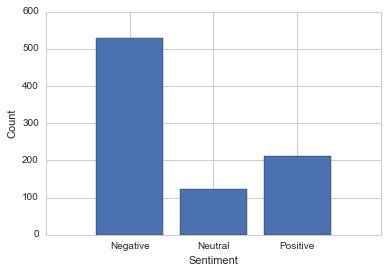

In [206]:
num_sent=all_data.groupby('sentiment').size().reset_index()
num_sent.columns=['sentiment','size']
fig=plt.figure()
plt.bar([.1,1.1,2.1],num_sent.loc[:,'size'])
plt.xticks([.5,1.5,2.5],[i.capitalize() for i in num_sent.sentiment])
plt.xlim([-.5,3.5])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

We've got a lot of upset people posting on this Subreddit! Let's take a peek at what they're talking about

In [212]:
for neg_post in all_data.loc[all_data.sentiment=='negative','raw_text'].sample(3):
    print neg_post+'\n'
    print '*****************************'

Anyone else having problems with Viral Mturk hits?  First two I tried had videos removed at YT.  Third and fourth hits I skipped two displayed blank urls in the hit page. 

*****************************
Is this normal for survey's to ask you this.  I am pretty new and still learning the ropes.  I thought they were suppose to ask you any ID information.

*****************************
I didn't take it - My sister warned me first. Apparently, after completing the whole survey, it tells you that you are not in the right demographic. TO confirms, all her reviews mention the same thing.

*****************************


And the happy people?

In [216]:
for pos_post in all_data.loc[all_data.sentiment=='positive','raw_text'].sample(3):
    print pos_post+'\n'
    print '*****************************'

What are the best ones I should be requesting?  Been turking for a few months but I often miss out on some because of qualifications that I'm yet to request.

*****************************
I recently applied to Mturk and was rejected. I am from Canada so I was kind of expecting to be rejected but I was just wondering how long I should wait until I reapply? If anyone has had any experience of being rejected but then reapplying and being accepted it would be greatly appreciated. 

Thank you.

*****************************
i have been turking since November, 2015 with 2684 approved HITs! i saw someone just reached his first grand with a little less than that number of HITs!! 
http://imgur.com/vxZN08u

Learned lesson: stay in school!

*****************************


Ok, I'd say we're getting some signal out of this. The negative posts seem pretty negative and the positive posts, while not exuberant, do seem happier (or at least less aggressively negative, which I guess is what passes for positive on certain parts of the internet?).

# Topic modeling

But what are people in general saying in these posts? I'm going to run a Latent Dirichlet allocation topic model to get a nice summary.

In [217]:
from sklearn.decomposition import LatentDirichletAllocation

And here's a function to get our diagnostic features out of the model

In [233]:
def get_top_features(lda_model,tf_feature_names,n,verbose=False):
    features_weights=lda_model.components_
    top_features={}
    for w_i,weights in enumerate(features_weights):
        
        best_features=[]
        ranks=len(weights)-sp.stats.rankdata(weights)
        for best in range(n):
            feature=tf_feature_names[np.where(ranks==best)[0][0]]
            best_features.append(feature)
        if verbose:
            print 'Component '+str(w_i)
            print ', '.join(best_features)
        top_features['Component '+str(w_i)]=best_features
    top_features_df=pd.DataFrame(top_features).transpose()
    top_features_df.loc[:,'topic']=range(len(features_weights))
    return top_features_df

## General topic model

First let's run the topic model on all of our data together

In [302]:
all_fname='all_lda.pkl'
all_sent_text=all_data.proc_text2
if not os.path.exists(all_fname):

    n_features=100
    tf_vectorizer = CountVectorizer(min_df=5, max_features=n_features,stop_words='english')
    all_tf = tf_vectorizer.fit_transform(all_sent_text)

    # Fit LDA on all test
    all_lda_model=LatentDirichletAllocation(n_topics=4)
    all_lda_model.fit(all_tf);
    all_tf_feature_names = tf_vectorizer.get_feature_names()
    
    with open(all_fname,'wb') as post_file:
        pk.dump((all_lda_model,all_tf_feature_names,all_tf),post_file)
else:
    with open(all_fname,'rb') as post_file:
        all_lda_model,all_tf_feature_names,all_tf=pk.load(post_file)

all_top_features=get_top_features(all_lda_model,all_tf_feature_names,15,verbose=False)   
all_top_features

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,topic
Component 0,hit,survey,requester,want,like,got,rejected,surveys,rejection,minutes,bonus,people,dont,work,way,0
Component 1,account,amazon,hit,email,payments,mturk,tried,bank,information,got,click,page,dont,try,message,1
Component 2,hits,mturk,thanks,time,need,dont,work,know,guys,help,new,turk,available,like,wondering,2
Component 3,hits,day,like,days,turking,hit,approved,10,time,batch,today,make,work,batches,know,3


This table tells us what words were most diagnostic for each of our components/topics. And I've ordered the words, 0->15, such that word 0 has the strongest influence and the influence of each word decreases subsequently. That being said, we have 100 features, so latter words in aggregate can play an important role

### Diving into our topics

And now let's get the topics of our posts

In [273]:
all_data.loc[:,'topic']=[np.argmax(i) for i in all_lda_model.transform(all_tf)]

In [297]:
all_data.groupby('topic').size()

topic
0    205
1    163
2    249
3    249
dtype: int64

To get a better idea of what our topics are, I'm going to find the posts that were most exemplary of each topic. So, for each posts I'm going to find the probability of it coming from each topic and then for each topic find the post that had the highest probability of belonging to it (vs. another topic)

In [295]:
topics=np.unique(all_data.loc[:,'topic'])
weights=all_lda_model.transform(all_tf)
norm=repmat([ [i] for i in np.sum(weights,axis=1)],1,len(topics))
best_id=np.argmax(weights/norm,axis=0)

### Topic 0: Requester looking for Requester

Let's look at our first topic

In [296]:
ind=0
samp_post=all_data.iloc[best_id[ind],:]
print 'Component '+str(ind)
print str(samp_post.raw_text)
print '\n*************************\n'

Component 0
I have a survey that I recently posted on MTurk and will be posting again. The survey involves some free response questions that we really want people to take their time with and think about. In the last batch we posted, there were an alarming number of workers who didn't give adequate answers-- they were either way underdeveloped (i.e., three words where sentences were clearly called for), or fairly nonsensical (I suspected bots in this situations, though I suppose someone not very good at English could have produced some of these responses). We had a few attention checks that people missed too. 

My question is, for the next go, is there some way we can discourage the people who might not be willing to put in time and thought to this survey? We already mention in the HIT description that it will involve a writing exercise and ask that people not do it unless willing to engage in that, and I don't think that the survey being overlong or mind-numbingly boring is the problem

This topic seems to do mostly with posts from requesters who are trying to figure out how to make better studies. For example, looking at the feature words we see some mentions of **rejecting/rejection of** turkers, **minutes**, **bonuses**.

### Topic 1: Blame it on Amazon

In [298]:
ind=1
samp_post=all_data.iloc[best_id[ind],:]
print 'Component '+str(ind)
print str(samp_post.raw_text)
print '\n*************************\n'

Component 1
I made up mechanical turk account I filled up my information and address then amazon payments told me to enter my information I filled it all then they sent me that the vertification failed and my account is suspended I saw on reddit forum that I must fill my tax information  I filled it and until now status is pending I don't know if the status changed to accept my account could be unsuspended I made a new account until I see what will happen I made my account mechanical turk then I filled my current address and security question and agree then they send me emal to verify my email address I verified before I enter my amazon payments account information I edit the tax information today then they said that I work on hits until they verify my tax information when I click on accept hit they send me to amzon payments to enter my information so idont know now wait until the tax is verified to avoid account suspended or I fill my information in amzon payments they might verify it

Pretty straightforward--people who have problems with the Mechanical Turk system instead of studies themselves. This person seems to have gone through quite the ringer

### Topic 2: How to HIT good

In [299]:
ind=2
samp_post=all_data.iloc[best_id[ind],:]
print 'Component '+str(ind)
print str(samp_post.raw_text)
print '\n*************************\n'

Component 2
And yes, I swear I searched before posting this! :)  
It's my first time doing any of their HITs and I have a shoe question.  
Rather, the bounding box question. It doesn't say if you are to draw the bounding box even if the shoe (or other item) is not what they are looking for.    

Does anyone do enough of these to know? I submitted about 4, and didn't do the bounding box, so either I did 2 right and 2 wrong, either way.  

Edit: Thanks for everyone's help. All were approved just fine.

Gracias.

*************************



This topic may be HIT advice (honestly I'm a bit unsure)? The words like **need**, **work**, and **know** do make it seem somewhat skill based? Those words *are* in the next topic too, albeit lower ranked, but there they may reflect the qualifications necessary for certain HITs

### Topic 3: Spaceballs 2: The Search for More Money

In [300]:
ind=3
samp_post=all_data.iloc[best_id[ind],:]
print 'Component '+str(ind)
print str(samp_post.raw_text)
print '\n*************************\n'

Component 3
I've been turking for about 3 months now and recently started using hitscraper. I've definitely noticed an increase in my pay. I've been able to grab several very juicy hits that I doubt I would've gotten otherwise. My question: is there a way to make hitscraper auto accept hits? The best ones that come in I can only seem to get about 25% of the time. This is while I'm working on a hit in one tab I react to the beep and try to PANDA the new good one. If I don't get it, I put it into turkmaster and auto accept it. This ends yielding me the hit about 10% of the time. How should I use these two scripts together? I mostly do surveys. Can never seem to find profitable batches. 

*************************



This topic seems to be about how mturkers can get HITs and more $$$, based on the presence of words like **day** and **batch**

### Takeaway

The topic model appears to be recovering some interesting categories. We've got requesters in one group, and then account, HIT and how to find HITs topics in their own groups. To some extent, these topics even seem to reflect the [tags in the subreddit](https://www.reddit.com/r/mturk/) like "Requester help" and "Qual/HIT question"

And that brings us to our next analyses--what are negative/positive valence people posting about?

## Negative sentiment topic model

Now let's see what people like to complain about. I'm going to run an LDA on **just** the negative posts people wrote

In [303]:
neg_fname='neg_lda.pkl'
neg_sent_data=all_data.loc[all_data.sentiment=='negative',:]
neg_sent_text=neg_sent_data.proc_text2
if not os.path.exists(neg_fname):

    n_features=100
    tf_vectorizer = CountVectorizer(min_df=5, max_features=n_features,stop_words='english')
    neg_tf = tf_vectorizer.fit_transform(neg_sent_text)

    # Fit LDA on all test
    neg_lda_model=LatentDirichletAllocation(n_topics=4)
    neg_lda_model.fit(neg_tf);
    neg_tf_feature_names = tf_vectorizer.get_feature_names()
    
    with open(neg_fname,'wb') as post_file:
        pk.dump((neg_lda_model,neg_tf_feature_names,neg_tf),post_file)
else:
    with open(neg_fname,'rb') as post_file:
        neg_lda_model,neg_tf_feature_names,neg_tf=pk.load(post_file)

neg_top_features=get_top_features(neg_lda_model,neg_tf_feature_names,15,verbose=False)   
neg_top_features

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,topic
Component 0,hits,like,survey,people,approved,use,surveys,using,100,turking,day,new,didnt,days,hit,0
Component 1,hit,hits,time,tried,dont,work,click,mturk,says,message,new,try,page,doesnt,search,1
Component 2,account,amazon,dont,know,payments,money,mturk,bank,need,really,right,didnt,say,start,able,2
Component 3,got,hits,like,mturk,requester,hit,work,email,way,requesters,dont,time,make,really,information,3


In [308]:
neg_sent_data.loc[:,'topic']=[np.argmax(i) for i in neg_lda_model.transform(neg_tf)]

In [309]:
neg_sent_data.groupby('topic').size()

topic
0    117
1    165
2     80
3    168
dtype: int64

In [313]:
topics=np.unique(neg_sent_data.loc[:,'topic'])
weights=neg_lda_model.transform(neg_tf)
norm=repmat([ [i] for i in np.sum(weights,axis=1)],1,len(topics))
best_id=np.argmax(weights/norm,axis=0)

### Topic 0: Turkers on probation

In [314]:
ind=0
samp_post=neg_sent_data.iloc[best_id[ind],:]
print 'Component '+str(ind)
print str(samp_post.raw_text)
print '\n*************************\n'

Component 0
There's some days where there's a really nice batch that I can't do more than 80-100 and it's really annoying. Like the Horse Name one today.

They should make it like that : 

- You are no longer in probation if you complete 100 or more hits and earn 30$ during the first 10 days. If you hit that goal during the second day, you are no longer in probation afterwards.

Like I made 60$ in the past 7 days with 430 HITS approved. 98.9% Accuracy. Like comon, did I not gain your trust yet? :P

*************************



This one seems to reflect Turkers who, for whatever reason, got flagged. **day** seems to be indicative of how long they're on probation.

### Topic 1: REQUESTERS DEBUG YOUR CODE

In [319]:
ind=1
samp_post=neg_sent_data.iloc[best_id[ind],:]
print 'Component '+str(ind)
print str(samp_post.raw_text)
print '\n*************************\n'

Component 1
I try to submit my code and I get this error:

 There was a problem submitting your results for this HIT.

This HIT is still assigned to you. To try this HIT again, click "HITs Assigned To You" in the navigation bar, then click "Continue work on this HIT" for the HIT. If this problem persists, you can contact the Requester for this HIT using the "Contact" link above.

To return this HIT and continue working on other HITs, click the "Return HIT" button.


I tried everything and it still won't let me hit submit.  Help?

*************************



Ok requesters, make sure your HITs work! Test them out in sandbox and when you do deploy them, keep an eye until the first few turkers complete your study. It took me a few HITs to really discipline myself on this. In the feature words, we can see things like **click**, **don't/doesn't** and **tried**.

### Topic 2: Blame it on Amazon (redux)

In [320]:
ind=2
samp_post=neg_sent_data.iloc[best_id[ind],:]
print 'Component '+str(ind)
print str(samp_post.raw_text)
print '\n*************************\n'

Component 2
I have around $150 that I earned Turking in the last week or so in my Amazon Payments account. In the past, I have used my Turking earnings to buy merchandise from Amazon.com. But now, I really need my money.

I tried to set up my bank account with Amazon Payments. As part of their verification process they sent 2 small random deposits to my account. When I went to verify my account using the amounts of these deposits, they said they were unable to verify that I had control of the account I was attempting to add, "FOR MY PROTECTION."

I tried to send screenshots of the emails that I got from my bank informing me of the 2 deposits, but they rejected that info saying that screenshots were not acceptable, and that I needed to send a bank statement. Cool, because my bank statement just happened to arrive the next day, and YES, the two random deposits were actually on the bank statement. What more could you ask for?

Well, I sent the bank statement. But the bad news is that my b

People who had trouble with Amazon (similar to the Amazon cluster in the previous aggregate analysis)

### Topic 3: Cautionary tales of horrible requesters

In [321]:
ind=3
samp_post=neg_sent_data.iloc[best_id[ind],:]
print 'Component '+str(ind)
print str(samp_post.raw_text)
print '\n*************************\n'

Component 3
With out having to write out the entire episode that has happened with this requester (I want to but I am at work currently), please be careful of this requester. He has been in here a couple times and in IRC. He is rude and thinks of us as the scum that does the work for him, and if you disagree, he will send you 3 emails to let you know how mad he is at you. What type of REQUESTER does this? None that I know of that are professional.
Here is one of the emails I was sent. https://gyazo.com/81f9157b8cd2a38a23b226726f94fece
Little background:
 
* He came into IRC to ask our opinions on his hits, didn't like our answers, got mad and called us the lower workers (not exact words)
* Came back with a new name and tried again in PMs. I talked to him for about 30 minutes. He said he would bonus me for helping him and even asked for my ID -Never received bonus, messaged him, no reply.
* Went on TO, wrote a TRUTHFUL review of him and went about my day.
* Got a bonus and a email from 

And requester horror stories. This post in particular is quite detailed. Obviously, **requester** and **email** were key features. There's no subtle point to take away from this, just, act like a decent human being and treat people with respect. Don't play mindgames or form Ponzi schemes.

## Positive sentiment topic model

And finally let's see what people are speaking positively about by running an LDA on just the posts that were classified as positive

In [323]:
pos_fname='pos_lda.pkl'
pos_sent_data=all_data.loc[all_data.sentiment=='positive',:]
pos_sent_text=pos_sent_data.proc_text2
if not os.path.exists(pos_fname):

    n_features=100
    tf_vectorizer = CountVectorizer(min_df=5, max_features=n_features,stop_words='english')
    pos_tf = tf_vectorizer.fit_transform(pos_sent_text)

    # Fit LDA on all test
    pos_lda_model=LatentDirichletAllocation(n_topics=4)
    pos_lda_model.fit(pos_tf);
    pos_tf_feature_names = tf_vectorizer.get_feature_names()
    
    with open(pos_fname,'wb') as post_file:
        pk.dump((pos_lda_model,pos_tf_feature_names,pos_tf),post_file)
else:
    with open(pos_fname,'rb') as post_file:
        pos_lda_model,pos_tf_feature_names,pos_tf=pk.load(post_file)

pos_top_features=get_top_features(pos_lda_model,pos_tf_feature_names,15,verbose=False)   
pos_top_features

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,topic
Component 0,hits,survey,approved,bonus,people,mturk,going,pay,make,today,complete,surveys,like,good,thanks,0
Component 1,got,account,thanks,way,hits,amazon,earnings,ago,approved,qualification,script,reason,say,hello,mturk,1
Component 2,hits,thanks,time,days,hit,mturk,day,good,new,guys,dont,scripts,work,really,got,2
Component 3,amazon,account,hit,email,requester,mturk,turk,work,hits,contact,new,like,payments,help,use,3


In [324]:
pos_sent_data.loc[:,'topic']=[np.argmax(i) for i in pos_lda_model.transform(pos_tf)]

In [325]:
pos_sent_data.groupby('topic').size()

topic
0    63
1    17
2    96
3    36
dtype: int64

In [335]:
topics=np.unique(pos_sent_data.loc[:,'topic'])
weights=pos_lda_model.transform(pos_tf)
norm=repmat([ [i] for i in np.sum(weights,axis=1)],1,len(topics))
best_id=np.argmax(weights/norm,axis=0)

### Topic 0: Your friendly, neighborhood Requestor

In [328]:
ind=0
samp_post=pos_sent_data.iloc[best_id[ind],:]
print 'Component '+str(ind)
print str(samp_post.raw_text)
print '\n*************************\n'

Component 0
Hello, I'll be posting a survey on MTurk for the first time within the next ten days. The survey itself will be approximately 30 items long and will take approximately 2.5-5 minutes to complete. I'm going to need approximately 500 people to complete this survey and plan on paying my turkers $.75 for this task. 

However, I am concerned about the potential for inattentive respondents. Given that I am trying to examine the psychometric properties of these survey items for subsequent research, inattentive responding (i.e., Christmas-treeing the survey) would really throw a wrench in my work. 

1) Is $.75 enough to induce people to respond attentively for a 2.5-5 minute survey?

2) I am planning on incorporating quality control items (e.g., "Please select "slightly agree") in order to detect inattentive respondents. I'm also considering flagging people who complete the survey far too quickly ( < 1 minute or so). Are there any other methods commonly used in the turk community to

Coming off of the preceding horror story, this is the kind of requestor you should be--Concerned about the quality of your data, aware that you are paying people a small amount to do what is probably a boring task and the sense of humor of a sitcom parents from the 50's.

### Topic 1: Stories of forgiveness

In [329]:
ind=1
samp_post=pos_sent_data.iloc[best_id[ind],:]
print 'Component '+str(ind)
print str(samp_post.raw_text)
print '\n*************************\n'

Component 1
I've been a turker since 2009, when I first turned 18. I'm a masters worker with 98% approval rating. At least, I was a turker until yesterday afternoon. Yesterday amazon suspended my account out of the blue, stating blocks as the reason.

I've had one hard block in the last 6 months: John Wilson blocked me back in February. I've had 2 "soft" blocks since then, with no account warnings. 

One came from S. Eckard, who also blocked another worker on turkopticon. And the other one came from Jacob Dink. I must have gotten another soft block yesterday, though I don't know from who. I never got an account warning, so it had to be a soft block. But amazon took it upon themselves to suspend my account.

This is just a heads up to my fellow turkers: soft blocks DO count against you. So be careful out there!

Edit: Just a quick update. I sent three messages. On the first one, I got an automated message and then a real live human saying they would sent my case to the account suspensio

When I first started reading this post, I thought "Omg my sentiment classifier sucks. But I got to the end and the moral of this topic seems to be, "People on the internet make mistakes and *sometimes* we fix them". Note the emphasis on the *sometimes*; this is the rarest category. The LDA feature **thanks** is probably pretty diagnostic of that.

### Topic 2: Spaceballs 3: The Search for Even More Money

In [330]:
ind=2
samp_post=pos_sent_data.iloc[best_id[ind],:]
print 'Component '+str(ind)
print str(samp_post.raw_text)
print '\n*************************\n'

Component 2
I've been turking for about 3 months now and recently started using hitscraper. I've definitely noticed an increase in my pay. I've been able to grab several very juicy hits that I doubt I would've gotten otherwise. My question: is there a way to make hitscraper auto accept hits? The best ones that come in I can only seem to get about 25% of the time. This is while I'm working on a hit in one tab I react to the beep and try to PANDA the new good one. If I don't get it, I put it into turkmaster and auto accept it. This ends yielding me the hit about 10% of the time. How should I use these two scripts together? I mostly do surveys. Can never seem to find profitable batches. 

*************************



Yup, this post came up again! This time it seems to be representing some sort of Horatio Alger topic about how to get more HITs in less **time**/**days**.

### Topic 3

In [331]:
ind=3
samp_post=pos_sent_data.iloc[best_id[ind],:]
print 'Component '+str(ind)
print str(samp_post.raw_text)
print '\n*************************\n'

Component 3
I received an e-mail from Amazon about a block from Lab 322. Did anyone else receive this? I'm still pretty new (started on MTurk Jan 2) and not sure what, if anything, to do. I went through my spreadsheet and I've done two HITs for Lab 322, on March 2 and 11, and both with the same name (but different pay amounts). I don't remember what the surveys were about, but I wonder if they were the same surveys and that was why I was blocked.

Here's the e-mail:

Greetings from Mechanical Turk.

We regret to inform you that you were blocked from working on HITs by the following requester(s):

LAB 322

Requesters typically block Workers who submit poor quality work.

Should additional requesters block you in the next few months, we may suspend your account.

Regards,
The Mechanical Turk Team

Any help on what to do is appreciated. Thank you!

ETA: Sent message, received answer: "we found it to be of poor quality and ultimately unusable for our analyses". I take my time with all the 

Ok, this topic is something of a weird subset of people who politely asked for help **AND** also copied and pasted Amazon emails, as reflected by the most diagnostic word being **amazon**...let's not read too much into this.

# Negative posts in depth

This first round of sentiment classification and topic modeling has given us a broad overview of what people are talking about on the mturk subreddit. Sometimes people complain about a HIT, specific requesters, or some technical issue they have with Amazon.

Building on that, can we get any more specific tips for requesters, above and beyond "Don't be a jerk and debug your code?". I'm also going to try to give specific advice in response to these topics based on my own experience writing mturk studies

Let's get the subset of negative posts about task errors (neg_sent_data.topic==1) and requesters (neg_sent_data.topic==3)

In [400]:
requester_issue_data=neg_sent_data.loc[np.logical_or(neg_sent_data.topic==1,neg_sent_data.topic==3)].reset_index()
requester_issue_text=requester_issue_data.proc_text2

In [414]:
ri_fname='requester_issue_data.pkl'

if not os.path.exists(ri_fname):

    n_features=100
    tf_vectorizer = CountVectorizer(min_df=5, max_features=n_features,stop_words='english')
    ri_tf = tf_vectorizer.fit_transform(requester_issue_text)

    # Fit LDA on all test
    ri_lda_model=LatentDirichletAllocation(n_topics=8)
    ri_lda_model.fit(ri_tf);
    ri_tf_feature_names = tf_vectorizer.get_feature_names()
    
    with open(ri_fname,'wb') as post_file:
        pk.dump((ri_lda_model,ri_tf_feature_names,ri_tf),post_file)
else:
    with open(ri_fname,'rb') as post_file:
        ri_lda_model,ri_tf_feature_names,ri_tf=pk.load(post_file)

ri_top_features=get_top_features(ri_lda_model,ri_tf_feature_names,15,verbose=False)   
ri_top_features

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,topic
Component 0,hit,hits,time,accept,way,available,know,click,mturk,dont,requester,thanks,question,turking,working,0
Component 1,requester,hit,got,hits,rejection,like,rejected,didnt,wrong,sure,said,survey,thanks,mturk,help,1
Component 2,turk,bad,ago,started,really,mechanical,like,things,got,good,say,account,hits,sorry,know,2
Component 3,hits,hit,page,says,mturk,task,search,trying,problem,try,new,script,qualification,getting,working,3
Component 4,account,email,hit,information,submit,click,bonus,requester,work,turk,message,got,sent,link,mechanical,4
Component 5,tried,hit,qualified,turkmaster,email,work,today,got,times,getting,edit,new,know,ago,sure,5
Component 6,like,time,make,way,sorry,rejections,survey,dont,questions,workers,work,hours,thanks,help,mturk,6
Component 7,hits,dont,work,day,like,requesters,pay,mturk,want,good,batch,surveys,getting,really,hit,7


And let's look at these components in more detail

In [415]:
requester_issue_data.loc[:,'topic']=[np.argmax(i) for i in ri_lda_model.transform(ri_tf)]

In [416]:
requester_issue_data.groupby('topic').size()

topic
0    49
1    59
2    15
3    69
4    22
5    19
6    42
7    58
dtype: int64

In [417]:
topics=np.unique(requester_issue_data.loc[:,'topic'])
weights=ri_lda_model.transform(ri_tf)
norm=repmat([ [i] for i in np.sum(weights,axis=1)],1,len(topics))
best_id=np.argmax(weights/norm,axis=0)

# Topic 0: Make sure people can accept your HIT

In [418]:
ind=0
samp_post=requester_issue_data.iloc[best_id[ind],:]
print 'Component '+str(ind)
print str(samp_post.raw_text)
print '\n*************************\n'

Component 0
This is the third time I've tried to do a HIT by this requester since I started turking, and for the third time I can't submit it! (The HIT about searching youtube)

People absolutely love this guy and lavish mountains of praise about him on TO, but I can NEVER get his HITs to work :( I've already wasted over 20 minutes so it's no longer worth the $2.

So, is it just me that can never seem to do a SS HIT?

(I was able to do the join a group one, but it had no form so I don't really count it)

*************************



Based on this post and the features **accept** (3) and **click** (7), as a requester make sure people can **Accept** and **Submit** your HIT. 

Some possible reasons this wouldn't work:

* You have a check on who can accept your HIT (e.g., using Chrome, not a repeat subject) which is either not working or isn't obvious to your subjects
* You have a button with a link to a page with a typo or filepath that you changed
* You didn't submit the HIT with an assignmentId
* You left the submit link set to sandbox mode

### Topic 1: Rejection hurts

In [419]:
ind=1
samp_post=requester_issue_data.iloc[best_id[ind],:]
print 'Component '+str(ind)
print str(samp_post.raw_text)
print '\n*************************\n'

Component 1
I'll try to long story short. I just started doing mturk and haven't done many HITs (having trouble finding HITs I can do and also doing more than 3 or 4 an hour but that's another issue entirely). I did a table extraction from requester Recognos Dst and got rejected with this message "Rejected. The tablewrong extracted." (this is copy pasted from the rejection msg).


Now, I saw a lot of these table extraction jobs from them and looked at the files ahead of time, which maybe I'm doing something wrong but I couldn't find the info they wanted in 3 of the posts (of a specific type of table) and waited until I found one that had the EXACT header (there were many that had close headers and I didn't attempt those HITs). I only did one HIT from them because I am nervous of rejections right now since I am so new and want to spread around the types in case I encounter a problem.

Well I woke up this morning to this rejection and I'm panicking because again, not many HITs right now 

The focus here is **rejection** (4). Rejection is a pain for mturkers and there are a good number of people trying to make a living on mturk. Do not reject people unless there is really good evidence they are doing the bare minimum (e.g., clicking the same button the entire time). 

Generally, try to design your tasks so that it is hard for people to do the lazy thing and minimize unpleasantness. This is more of a design or UX question, like if you're afraid subjects are going to press a single button then make sure they have to move the mouse between trials.

### Topic 2: ???

In [420]:
ind=2
samp_post=requester_issue_data.iloc[best_id[ind],:]
print 'Component '+str(ind)
print str(samp_post.raw_text)
print '\n*************************\n'

Component 2
Sorry if it's in the FAQ, I can't seem to find any info.

I started literally 2 days ago and I can't seem to get my numbers up.

I can't seem to do the ones by A9 because I'm not from the US :(. So my question is, being from SPAIN, am I just doomed to do shitty receipt tasks? I did a couple ones but didn't take long to realize they aren't worth it.

Maybe I just don't know how to search? But searching the "ones I'm qualified for" only returns poor results. 14 pages. Most of them receipts and other document transcription.

Should I create a US account with a US friend info and start over? How long does it take to get accepted? I got the email that I was accepted 3 days ago and I don't even remember when I sent the appliance.

Can I just change where I live? Anyone in the same situation? The threads with the nice hits almost always ask to be from the US.

Sorry for the bad wording, my redacting skills sucks + english no mother language + nap time in spain.

******************

Ok, I'm not sure what this one is about. I'm having difficulty combining the post and the key words into a coherent message. It's also the smallest category which may mean it's a bit of a hodgepodge. The most representative post itself is concerned about regional qualifications which segues nicely into...

### Topic 3: Qualifications

In [421]:
ind=3
samp_post=requester_issue_data.iloc[best_id[ind],:]
print 'Component '+str(ind)
print str(samp_post.raw_text)
print '\n*************************\n'

Component 3
I have been having an issue lately. I can take a qualification test or be granted a qualification and when I go to do the hit, I meet all the qualifications but it says I can't do the hit.

I reached out to mturk, but of course, got nothing. They told me to contact the requester. This has happened with 3 different requesters so far.

Also, yesterday, before the issue with mTurk not working, a requester told me not to do anymore of their hits in that batch because the qualifications that had put to prevent retakes wasn't working. They said that I wasn't the only one that could do the hits even though there was a qual in place to prevent this.

Here is a screenshot of one of the hits I can't do: http://imgur.com/gcroyX1

*************************



This component seems like it might concern qualifications for HITs (feature word **qualification** (12)). Frankly, I rarely use qualifications (except for making sure turkers are from the US if that's important to my task).

My advice is keep an eye on the qualifications you have set up for your HIT. Sometimes these will be important for your study, sometimes things will wash out. As a psychologist, I tend to like studying effects that are robust even amongst diverse populations doing my study through the internet. And with good experiment design (see topic 2), you don't need qualifications that weed out turkers with poor ratings.

### Topic 4: Check your email and compensate your turkers

In [422]:
ind=4
samp_post=requester_issue_data.iloc[best_id[ind],:]
print 'Component '+str(ind)
print str(samp_post.raw_text)
print '\n*************************\n'

Component 4
Have you ever had a requester say they sent you a bonus, but you never got an email? How can the requester verify it was sent? If they send tons of bonuses and/or post tons of hits, they might not notice the money being debited for one specific user, so how can they figure it out?

This came up today from a worker in IRC, and it got me thinking. There's got to be a way to verify bonus payments as a requester, since the transactions don't show up in your account. Well, after some digging, I figured it out:

1. Go to the [manage](https://requester.mturk.com/manage) site
1. Click on [Manage Hits Individually](https://i.gyazo.com/2f9be62575414fc6f9116d43dbaddad9.png)
1. Click on [Download Results](https://i.gyazo.com/2515a1475045d634d82ce60aacb1419c.png) for the hit you wish to verify.
1. Click on [Approved](https://i.gyazo.com/f333b301b71dc495929bdcaed081c3ae.png) to view all the approvals for that hit
1. Search for the worker ID with ctrl+f

If the worker has been bonused, yo

On mturk, you might give bonuses (key word **bonus** (6)) because:

#### You want to motivate good performance

Giving performance based bonuses are a good way to motivate turkers. Good design can only go so far in encouraging people to do an unavoidably dull task well. If you've got the time and funds, give a little monetary incentive (though, [as this excellent study shows from Crump, McDonnell and Gureckis (2013), ](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0057410) certain studies benefit more from extra cash).

#### You messed up and people are yelling at you 

Your code gone goofed up and now your inbox (key word **email** (1)) is full of angry emails. Since in many cases these subjects weren't able to complete your HIT, I have a separate HIT that I can direct people to where I can give them a bonus to compensate them. Make sure you're courteous in the email--as these analyses have shown, mturkers talk to each other


Note, this post is a little odd. I don't entirely get the gist of it; it seems to deal more with some internal system minutiae I'm not familiar with

### Topic 5: More qualification issues

In [423]:
ind=5
samp_post=requester_issue_data.iloc[best_id[ind],:]
print 'Component '+str(ind)
print str(samp_post.raw_text)
print '\n*************************\n'

Component 5
I just got an email while I was attempting to work on a UserBob HIT and it said my qualification was revoked. I hadn't even completed the HIT, so I'm not sure what's up...? Has this happened to anyone else? I was kind of disappointed since I just qualified for his HITs two or three days ago and I haven't really gotten an opportunity to do any until today.

*************************



This seems like more issues with qualifications (Topic 3), except maybe with the addendum that people were notified through email

### Topic 6: Time==Money

In [424]:
ind=6
samp_post=requester_issue_data.iloc[best_id[ind],:]
print 'Component '+str(ind)
print str(samp_post.raw_text)
print '\n*************************\n'

Component 6
Hey guys,

I've been browning this subreddit and all the other ones listed on the sidebar. Of course, I also read the FAQ. There are just a few things that are kind of unclear for me so I thought I would ask and see if anyone wanted to answer. I appreciate anyone who reads this and takes the time to answer. I'm sure it's annoying when new people pop up and want to ask questions. 

- Am I understanding properly that you can only transfer $500 per month to a bank account?

- My general goal for this is to make extra cash while I'm at my IRL job. The amount per day, or even hour, doesn't need to be consistent but I'm thinking maybe $150 per week. I work 30 hours a week and the majority of my time is absolutely free. My boss has no problem with me doing online work. He suggested it since I'm not enrolled in school. (Not Mturk - found it through r/beermoney).. Is this amount doable? 

- Probation period is 10 days, you have to do 3 hits a day, correct? 

- What are qualification

These posts seem to be concerned about ways to make the most money through mturk (key words **time** (1), **make** (2), **way** (3)). In general, make sure you pay turkers fairly. I usually aim for something like $4 per hour (plus or minus how enjoyable the task is). Try to say on the very first page in **LARGE BOLD FONT** how much money you will pay and how long the task will be

### Topic 7: Finding good HITs

In [425]:
ind=7
samp_post=requester_issue_data.iloc[best_id[ind],:]
print 'Component '+str(ind)
print str(samp_post.raw_text)
print '\n*************************\n'

Component 7
I'm not really able to do work outside my home atm. I'm newly disabled and still learning my limitations. I'm trying to make at LEAST $10 a day, but that's not really a lot when you're going to need to pay rent at some point. I'm still under 1000 HITS but above 500. Fell into some of the newb traps like p9r during my probation period to get my HITS up, but thankfully no random rejections. 
At this point it seems like my life is nothing but copying receipts, and I'm trying to find the most efficient requesters for the money atm. I'm spreadsheeting my time and earnings from different requesters, to see who I'm doing that pays best and within a reasonable amount of time, but I'm kind of sick of penny batching that is actually unfair amounts of work requested for the time it takes. 

I'm using turkopticon, but I'm having problems with installing any of the other scripts, and mostly I'm keeping window tabs of HITS from my preferred requesters open at all times, but even then, th

This is more about mturkers trying to find good HITs, nothing much that hasn't been covered in previous topics. This particular post does mention [Turkopticon](https://turkopticon.ucsd.edu/) though, which, if you're a requester who's not aware, is where all the mturkers go to rate you. If no one is doing your HIT, go to Turkopticon and see what your reputation looks like--a buggy HIT or misinterpreted/unread email may be dragging down your score.

# Conclusion

So, we were able to look at how mturkers are feeling on mturk and what they're talking about. And, in response to some of the more negative comments, I hope I was able to give some useful advice from my own experience about how to make better studies and interact with mturkers civilly :)

To recap:

* Don't go around rejecting people en masse; try improving experiment design instead
* Make sure people can Accept and Submit your HITs
* Experiment design can also help obviate the need for qualifications
* Bonuses are good motivators and a way to make up for mistakes
* Be upfront about task pay and length
* Be aware of your reputation (mturkers are organized!)

And the links I mentioned throughout this:

* [Mechanical Turk](https://www.mturk.com/mturk/welcome)
* [mturk subreddit](https://www.reddit.com/r/mturk/)
* [Hits Worth Turking For subreddit](https://www.reddit.com/r/HITsWorthTurkingFor/)
* [Turkopticon](https://turkopticon.ucsd.edu/). It also has a Chrome extension!
* [Crump, McDonnell and Gureckis (2013)](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0057410)